## 初始化与计算

In [687]:
import os,sys
sys.path.append('/home/zkd/文档/ION/Desktop/241209_393锁定/code')
from Photon_infere import *
import numpy as np

1. 创建对应turn的文件夹，将变量名`turn`改为对应值  
    1. 将ID1000文件夹下C3、C4的bin文件复制到turn文件夹下  
        C3、C4的bin文件夹名与ARTIQ中`experiment label`一致.  
        例如turn_0.635_C3_xxx.bin、turn_0.635_C4_xxx.bin,其中xxx为采数启动时间  
    2. 将alice、bob的谈探测文件复制到turn文件夹下，文件名分别更正为Alice.txt、Bob.txt  
    
2. 修改`period`为对应周期，单位为[s]  

3. 修改`window_start`、`window_end`为荧光计数窗口，一般与ID1000的窗口保持一致，单位为[ps]

4. 修改`time_start`、`time_stop`为分析数据截至时间，单位为[s]

In [688]:
os.chdir(r'/home/zkd/文档/ION/Desktop/241209_393锁定/20250304_BobEIT_Iris')

In [689]:
fold=os.listdir()
turns=[]
for i,_ in enumerate(fold):
    try:
        "{}".format(float(_.split('_')[0]))
        turns.append(_)
    except:
        pass
    print(i,_)
print(str(turns).replace('\'','"'))

0 0.545
1 sys.json
2 0.541
3 0.295
4 gamma_res_time.csv
5 gamma_fit_ref.jpeg
6 0.291
7 gamma_fit.jpeg
["0.545", "0.541", "0.295", "0.291"]


### 计算光子数

In [690]:
sys_json = read_sys_json('sys.json')

# 荧光计数窗口
window_start = sys_json['window_start(ps)']
window_end = sys_json['window_end(ps)']
# 分析数据截至时间
period = sys_json['period(s)']
time_start = sys_json['time_start(s)']
time_stop = sys_json['time_stop(s)']
# 脉冲
pulse_num = sys_json['pulse_num']
pulse_interval = sys_json['pulse_interval(ps)']
# 相位
turn = sys_json['turns'][-1]
# 外层计数验证
threshold = sys_json['threshold']
inner_loop = sys_json['inner_loop']

comment : This is a json file for TDC count.
blcok0 : count windows info
window_start(ps) : 433,000.0
window_end(ps) : 443,000.0
block1 : recquire time info
period(s) : 0.0005
time_start(s) : 0
time_stop(s) : 600000
block2 : pulse info
pulse_num : 9
pulse_interval(ps) : 5,000,000.0
block3 : turn / phase info
turns : ['0.291', '0.541', '0.545', '0.295']
block4 : windwo move info
window_start_list(ns) : [433.5, 435.5, 437.5, 439.5, 441.5, 443.5, 445.5, 447.5, 449.5]
window_len(ns) : 4
block5 : monitor pulse info
monitor_start(ps) : 45430500
monitor_end(ps) : 45431500
block6 : outer count info
threshold : 1
inner_loop : 100


In [ ]:
## 读取外层计数，得到需要忽略的序列
outer_count = np.loadtxt(f'{turn}/MultiPulse_EG_PreCount.txt')
drop_index = np.where(outer_count <= threshold)[0]
drop_list = []
for i in range(50):
    drop_list += list(drop_index + i)
drop_list = np.array(list(set(drop_list)))
drop_inner_index = []
for drop_ind in drop_list:
    drop_inner_index += list(range(drop_ind*inner_loop, (drop_ind+1)*inner_loop))
drop_inner_index = np.array(list(set(drop_inner_index)))

In [ ]:
pmt1_df=read_id900_binary(turn,3)
pmt2_df=read_id900_binary(turn,4)
## 添加反映数据是否因为离子雾化需要删除的序列
pmt1_df['delete'] = np.logical_not(np.isin(pmt1_df['start_index'], drop_inner_index))
pmt2_df['delete'] = np.logical_not(np.isin(pmt2_df['start_index'], drop_inner_index))
## 时间限制
pmt1_df=pmt1_df[(pmt1_df['start_index']>=time_start/period)&(pmt1_df['start_index']<=time_stop/period)&pmt1_df['delete']].copy()
pmt2_df=pmt2_df[(pmt2_df['start_index']>=time_start/period)&(pmt2_df['start_index']<=time_stop/period)&pmt1_df['delete']].copy()
# pmt1_df=pmt1_df[(pmt1_df['start_index']>=time_start/period)&(pmt1_df['start_index']<=time_stop/period)].copy()
# pmt2_df=pmt2_df[(pmt2_df['start_index']>=time_start/period)&(pmt2_df['start_index']<=time_stop/period)].copy()
## 计算时间窗内光子数
pmt1_index=window_index(pmt1_df,window_start,window_end,pulse_num=pulse_num,pulse_interval=pulse_interval)
pmt2_index=window_index(pmt2_df,window_start,window_end,pulse_num=pulse_num,pulse_interval=pulse_interval)
pmt1_count=pmt1_df[pmt1_index]['start_index'].value_counts().sort_index(ascending=True)
pmt2_count=pmt2_df[pmt2_index]['start_index'].value_counts().sort_index(ascending=True)
PMT1_SUM=pmt1_count.sum()
PMT2_SUM=pmt2_count.sum()
print('pmt1:{}, pmt2:{}'.format(PMT1_SUM,PMT2_SUM))
max_time=max(pmt1_count.index.max(),pmt2_count.index.max())*period
print('cps1:{}, cps2:{}'.format(PMT1_SUM/max_time,PMT2_SUM/max_time))

pmt1:294, pmt2:39
cps1:0.49469923043981956, cps2:0.06562336730324136


## 时域分布

 TDC histgram with pulse num:9, pulse interval:5.0us.


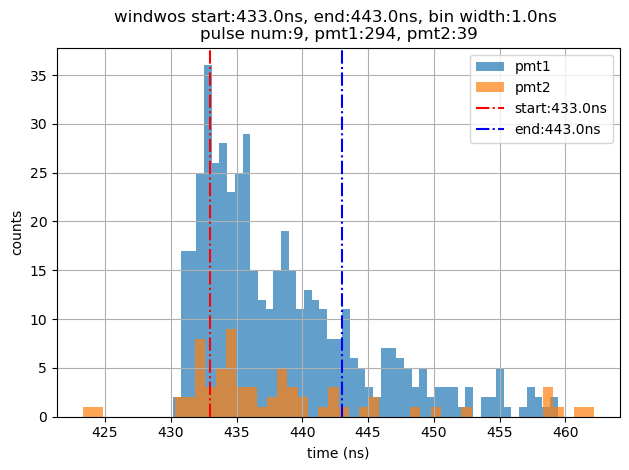

cumsum with pulse num:9.


/tmp/ipykernel_472901/1416087460.py:48: RuntimeWarning:

invalid value encountered in divide



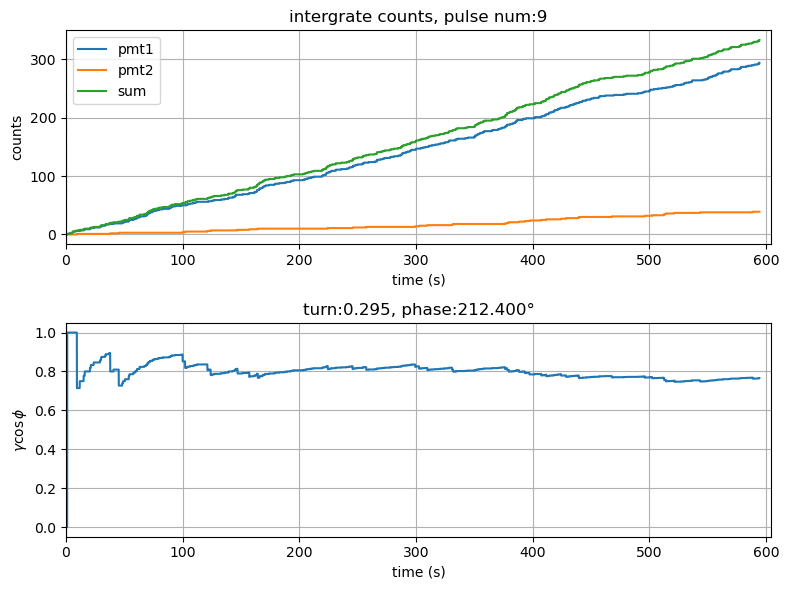

In [693]:
### 光子时间分布 
def hist_count(pmt1_df,pmt2_df,bin_t):
    """
    计数窗口内的光子数量，并绘制直方图展示不同探测器的光子计数随时间的分布。

    参数:
    pmt1_df (pandas.DataFrame): 第一个探测器的数据框，包含 'time_satmp' 列。
    pmt2_df (pandas.DataFrame): 第二个探测器的数据框，包含 'time_satmp' 列。
    bin_t (int): 直方图的时间间隔，单位为皮秒 (ps)。

    返回:
    无
    """
    hist_time_wid=20e3 # unit ps
    # bin_t=1000 #ps
    pmt1_hist_index=window_index(pmt1_df,window_start-hist_time_wid,window_end+hist_time_wid,pulse_num=pulse_num,pulse_interval=pulse_interval)
    pmt2_hist_index=window_index(pmt2_df,window_start-hist_time_wid,window_end+hist_time_wid,pulse_num=pulse_num,pulse_interval=pulse_interval)
    pmt1_hist_ts=pmt1_df['time_satmp'][pmt1_hist_index]%pulse_interval
    pmt2_hist_ts=pmt2_df['time_satmp'][pmt2_hist_index]%pulse_interval
    info='windwos start:{:,.1f}ns, end:{:,.1f}ns, bin width:{:.1f}ns \n'.format(window_start/1e3,window_end/1e3, bin_t/1e3)
    info+='pulse num:{}, pmt1:{:,.0f}, pmt2:{:,.0f}'.format(pulse_num,PMT1_SUM,PMT2_SUM)
    bin_wid=int((window_end-window_start+2*hist_time_wid)//bin_t) # width of bin is 100ps 
    plt.hist(pmt1_hist_ts/1000,bins=bin_wid,label='pmt1',alpha=0.7)
    plt.hist(pmt2_hist_ts/1000,bins=bin_wid,label='pmt2',alpha=0.7)
    plt.xlabel('time (ns)')
    plt.ylabel('counts')
    plt.axvline(window_start/1000,color='r',linestyle='-.',label='start:{:.1f}ns'.format(window_start/1000))
    plt.axvline(window_end/1000,color='b',linestyle='-.',label='end:{:.1f}ns'.format(window_end/1000))
    plt.legend(loc=1)
    plt.title(info)
    plt.tight_layout()
    plt.grid()
print(' TDC histgram with pulse num:{}, pulse interval:{:.1f}us.'.format(pulse_num,pulse_interval/1e6))
hist_count(pmt1_df,pmt2_df,bin_t=1000)
plt.savefig('./{}/histgram.jpeg'.format(turn),dpi=300)
plt.show()
### PMT 计数时间累积
def plot_cumsum(pmt1_count,pmt2_count,period=500e-6):
    "画出累加计数和相位估计"
    max_time=max(pmt1_count.index.max(),pmt2_count.index.max())
    time_index=np.arange(0,max_time+1,1)
    pmt1=np.zeros_like(time_index)
    pmt2=np.zeros_like(time_index)
    pmt1[pmt1_count.index]=pmt1_count.values
    pmt2[pmt2_count.index]=pmt2_count.values
    pmt1=pmt1.cumsum()
    pmt2=pmt2.cumsum()
    es_phase=(pmt1-pmt2)/(pmt1+pmt2)
    es_phase[es_phase!=es_phase]=0
    fig=plt.figure(figsize=(8,6))
    plt.subplot(211)
    plt.plot(time_index*period,pmt1,label='pmt1')
    plt.plot(time_index*period,pmt2,label='pmt2')
    plt.plot(time_index*period,pmt1+pmt2,label='sum')
    plt.axvline(time_start,color='r',linestyle='-.')
    plt.axvline(time_stop,color='r',linestyle='-.')
    plt.xlim(0,max_time*period+10)
    plt.legend(loc=2)
    plt.title('intergrate counts, pulse num:{:.0f}'.format(pulse_num))
    plt.xlabel('time (s)')
    plt.ylabel('counts')
    plt.grid()
    plt.subplot(212)
    plt.plot(time_index*period,es_phase,label='gamma')
    plt.axvline(time_start,color='r',linestyle='-.')
    plt.axvline(time_stop,color='r',linestyle='-.')
    plt.xlim(0,max_time*period+10)
    plt.xlabel('time (s)')
    plt.ylabel(r'$\gamma \cos{\phi}$')
    plt.title('turn:{}, phase:{:.3f}°'.format(turn,float(turn.split('_')[0])*360*2))
    plt.grid()
    plt.tight_layout()
    return fig
print('cumsum with pulse num:{:.0f}.'.format(pulse_num))
plot_cumsum(pmt1_count,pmt2_count,period=period)
plt.savefig('./{}/count_with_gamma_10pulse.jpeg'.format(turn),dpi=300)
plt.show()

## 单脉冲分析

   time[us]  pmt1  pmt2
0       0.0    42     3
1       5.0    28     7
2      10.0    30     4
3      15.0    37     5
4      20.0    35     2
5      25.0    31     3
6      30.0    37     2
7      35.0    26     5
8      40.0    28     8
all pmt1:294, pmt2:39


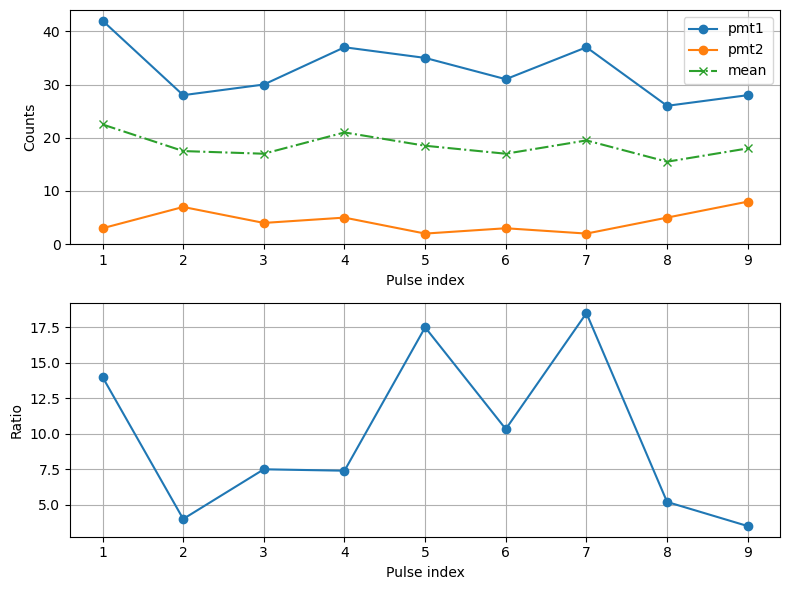

In [694]:
def pulse_count_df(pmt1_df,pmt2_df,pulse_interval=5e6,pulse_num=10,pulse_offset=0):
    """
    计算两个数据框（pmt1_df 和 pmt2_df）在一系列脉冲时间窗口内的脉冲计数，并将结果存储在一个 DataFrame 中。

    参数:
    pmt1_df (pandas.DataFrame): 第一个数据框，包含脉冲时间戳和起始索引。
    pmt2_df (pandas.DataFrame): 第二个数据框，包含脉冲时间戳和起始索引。
    pulse_interval (float, 可选): 脉冲间隔时间，默认为 5e6 ps。
    pulse_num (int, 可选): 要处理的脉冲数量，默认为 10。
    pulse_offset (int, 可选): 脉冲计数的起始偏移量，默认为 0。

    返回:  
    pandas.DataFrame: 包含每个脉冲的时间和两个数据框的脉冲计数的 DataFrame。
    """
    pulse_dict={'time[us]':[],'pmt1':[],'pmt2':[]}
    for pulse_i in range(pulse_offset,pulse_num):
        pulse_start=window_start+pulse_i*pulse_interval
        pulse_end=window_end+pulse_i*pulse_interval
        pmt1_pulse_index=window_index(pmt1_df,pulse_start,pulse_end)
        pmt2_pulse_index=window_index(pmt2_df,pulse_start,pulse_end)
        pmt1_pulse_count=pmt1_df[pmt1_pulse_index]['start_index'].value_counts().sort_index(ascending=True)
        pmt2_pulse_count=pmt2_df[pmt2_pulse_index]['start_index'].value_counts().sort_index(ascending=True)

        pulse_dict['time[us]'].append(pulse_i*pulse_interval*1e-6)
        pulse_dict['pmt1'].append(sum(pmt1_pulse_count))
        pulse_dict['pmt2'].append(sum(pmt2_pulse_count))
    return pd.DataFrame(pulse_dict)

pulse_df=pulse_count_df(pmt1_df,pmt2_df,pulse_num=pulse_num)
print(pulse_df)
print('all pmt1:{:,.0f}, pmt2:{:,.0f}'.format(np.sum(pulse_df['pmt1']),np.sum(pulse_df['pmt2'])))



def plot_pulse_counts(pulse_df):
    """
    绘制脉冲计数的可视化图表。

    参数:  
    pulse_df (pandas.DataFrame): 包含脉冲计数数据的 DataFrame，至少包含 'pmt1' 和 'pmt2' 列。

    返回:  
    matplotlib.figure.Figure: 包含绘制图表的 Figure 对象。
    """
    fig = plt.figure(figsize=(8,6))
    plt.subplot(2,1,1)
    plt.plot(1+pulse_df.index,pulse_df['pmt1'],'o-',label='pmt1')
    plt.plot(1+pulse_df.index,pulse_df['pmt2'],'o-',label='pmt2')
    plt.plot(1+pulse_df.index,(pulse_df['pmt1']+pulse_df['pmt2'])/2,'x-.',label='mean')
    plt.xticks(1+pulse_df.index)
    plt.xlabel('Pulse index')
    plt.ylabel('Counts')
    plt.legend()
    plt.grid()
    plt.subplot(2,1,2)
    if pulse_df['pmt1'].mean()>=pulse_df['pmt2'].mean():
        plt.plot(1+pulse_df.index,pulse_df['pmt1']/pulse_df['pmt2'],'o-')
    else:
        plt.plot(1+pulse_df.index,pulse_df['pmt2']/pulse_df['pmt1'],'o-')
    plt.xticks(1+pulse_df.index)
    plt.xlabel('Pulse index')
    plt.ylabel('Ratio')
    plt.grid()
    plt.tight_layout()
    return fig

plot_pulse_counts(pulse_df)
plt.savefig('./{}/pulse_counts.jpeg'.format(turn),dpi=300)
plt.show()

## Monitor pulse

In [695]:
moni_start=sys_json['monitor_start(ps)']
moni_end=sys_json['monitor_end(ps)']
## 计算时间窗内光子数
pmt1_index=window_index(pmt1_df,moni_start,moni_end,pulse_num=1)
pmt2_index=window_index(pmt2_df,moni_start,moni_end,pulse_num=1)
pmt1_count=pmt1_df[pmt1_index]['start_index'].value_counts().sort_index(ascending=True)
pmt2_count=pmt2_df[pmt2_index]['start_index'].value_counts().sort_index(ascending=True)
PMT1_SUM_moni=pmt1_count.sum()
PMT2_SUM_moni=pmt2_count.sum()
print('pmt1:{}, pmt2:{}'.format(PMT1_SUM_moni,PMT2_SUM_moni))
max_time=max(pmt1_count.index.max(),pmt2_count.index.max())*period
print('cps1:{}, cps2:{}'.format(PMT1_SUM_moni/max_time,PMT2_SUM_moni/max_time))

pmt1:21174, pmt2:47336
cps1:35.587421878348295, cps2:79.55824133529305


 TDC histgram with pulse num:9, pulse interval:5.0us.


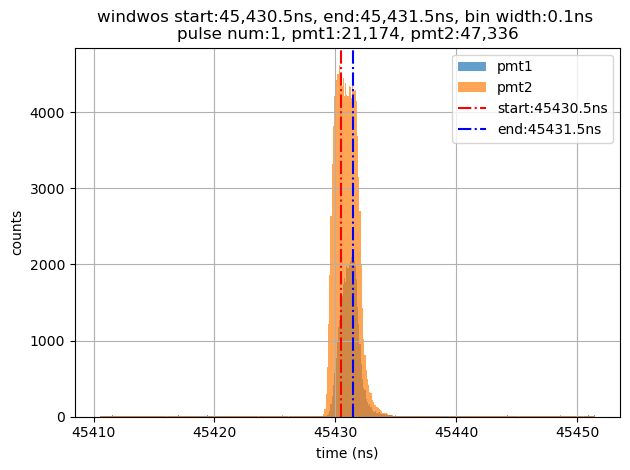

move average


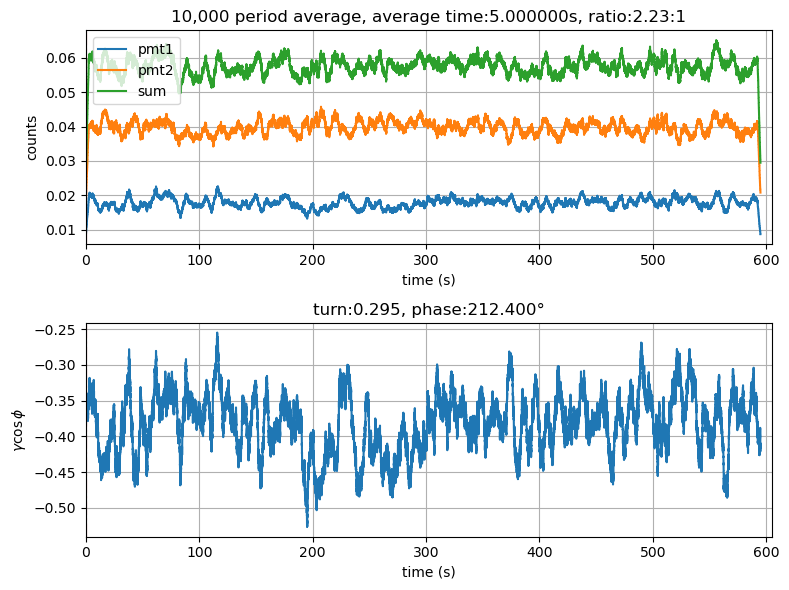

In [696]:
### 光子时间分布 
def hist_count(pmt1_df,pmt2_df,bin_t,window_start=window_start,window_end=window_end,pulse_num=pulse_num,pulse_interval=pulse_interval):
    """
    计数窗口内的光子数量，并绘制直方图展示不同探测器的光子计数随时间的分布。

    参数:
    pmt1_df (pandas.DataFrame): 第一个探测器的数据框，包含 'time_satmp' 列。
    pmt2_df (pandas.DataFrame): 第二个探测器的数据框，包含 'time_satmp' 列。
    bin_t (int): 直方图的时间间隔，单位为皮秒 (ps)。

    返回:
    无
    """
    hist_time_wid=20e3 # unit ps
    # bin_t=1000 #ps
    pmt1_hist_index=window_index(pmt1_df,window_start-hist_time_wid,window_end+hist_time_wid,pulse_num=pulse_num,pulse_interval=pulse_interval)
    pmt2_hist_index=window_index(pmt2_df,window_start-hist_time_wid,window_end+hist_time_wid,pulse_num=pulse_num,pulse_interval=pulse_interval)
    pmt1_hist_ts=pmt1_df['time_satmp'][pmt1_hist_index]%pulse_interval
    pmt2_hist_ts=pmt2_df['time_satmp'][pmt2_hist_index]%pulse_interval
    info='windwos start:{:,.1f}ns, end:{:,.1f}ns, bin width:{:.1f}ns \n'.format(window_start/1e3,window_end/1e3, bin_t/1e3)
    info+='pulse num:{}, pmt1:{:,.0f}, pmt2:{:,.0f}'.format(pulse_num,PMT1_SUM_moni,PMT2_SUM_moni)
    bin_wid=int((window_end-window_start+2*hist_time_wid)//bin_t) # width of bin is 100ps 
    plt.hist(pmt1_hist_ts/1000,bins=bin_wid,label='pmt1',alpha=0.7)
    plt.hist(pmt2_hist_ts/1000,bins=bin_wid,label='pmt2',alpha=0.7)
    plt.xlabel('time (ns)')
    plt.ylabel('counts')
    plt.axvline(window_start/1000,color='r',linestyle='-.',label='start:{:.1f}ns'.format(window_start/1000))
    plt.axvline(window_end/1000,color='b',linestyle='-.',label='end:{:.1f}ns'.format(window_end/1000))
    plt.legend(loc=1)
    plt.title(info)
    plt.tight_layout()
    plt.grid()
print(' TDC histgram with pulse num:{}, pulse interval:{:.1f}us.'.format(pulse_num,pulse_interval/1e6))
hist_count(pmt1_df,pmt2_df,bin_t=100,window_start=moni_start,window_end=moni_end,pulse_num=1,pulse_interval=moni_end+100e3)
plt.savefig('./{}/monitor_histgram.jpeg'.format(turn),dpi=300)
plt.show()
### PMT 计数时间累积
def plot_move_window(pmt1_count,pmt2_count,period=500e-6,inter_n=10000):
    "画出累加计数和相位估计"
    max_time=max(pmt1_count.index.max(),pmt2_count.index.max())
    time_index=np.arange(0,max_time+1,1)
    pmt1=np.zeros_like(time_index)
    pmt2=np.zeros_like(time_index)
    pmt1[pmt1_count.index]=pmt1_count.values
    pmt2[pmt2_count.index]=pmt2_count.values
    inter_n_array=np.ones(inter_n)/inter_n
    pmt1=np.convolve(pmt1,inter_n_array,mode='same')
    pmt2=np.convolve(pmt2,inter_n_array,mode='same')
    es_phase=(pmt1-pmt2)/(pmt1+pmt2)
    es_phase[es_phase!=es_phase]=0
    pmt1_m=pmt1.mean()
    pmt2_m=pmt2.mean()
    if pmt1_m>pmt2_m:
        ratio=pmt1_m/pmt2_m
    else:
        ratio=pmt2_m/pmt1_m
    
    fig=plt.figure(figsize=(8,6))
    plt.subplot(211)
    plt.plot(time_index*period,pmt1,label='pmt1')
    plt.plot(time_index*period,pmt2,label='pmt2')
    plt.plot(time_index*period,pmt1+pmt2,label='sum')
    plt.axvline(time_start,color='r',linestyle='-.')
    plt.axvline(time_stop,color='r',linestyle='-.')
    plt.xlim(0,max_time*period+10)
    plt.legend(loc=2)
    plt.title('{:,.0f} period average, average time:{:.6f}s, ratio:{:.2f}:1'.format(inter_n,inter_n*period,ratio))
    plt.xlabel('time (s)')
    plt.ylabel('counts')
    plt.grid()
    plt.subplot(212)
    plt.plot(time_index*period,es_phase,label='gamma')
    plt.axvline(time_start,color='r',linestyle='-.')
    plt.axvline(time_stop,color='r',linestyle='-.')
    plt.xlim(0,max_time*period+10)
    plt.xlabel('time (s)')
    plt.ylabel(r'$\gamma \cos{\phi}$')
    plt.title('turn:{}, phase:{:.3f}°'.format(turn,float(turn.split('_')[0])*360*2))
    plt.grid()
    plt.tight_layout()
    return fig
print('move average')
plot_move_window(pmt1_count,pmt2_count,period=period)
plt.savefig('./{}/monitor_gamma.jpeg'.format(turn),dpi=300)
plt.show()

## 输出到文件

In [697]:
out_csv='gamma_res_time.csv'
try:
    with open(out_csv, 'r') as f:
        pass
except FileNotFoundError:
    # 文件不存在，写入标题
    with open(out_csv, 'w') as f:
        f.write('turn,state,start(ps),end(ps),pmt1,pmt2,g,phase\n')

with open(out_csv,'a') as f:
    f.write('{a},origin,{t0:.0f},{t1:.0f},{pmt1:.0f},{pmt2:.0f},{g:.2%},{phase:.0f}\n'.format(a=turn.split('_')[0],t0=window_start,t1=window_end,pmt1=PMT1_SUM,pmt2=PMT2_SUM,g=(PMT1_SUM-PMT2_SUM)/(PMT1_SUM+PMT2_SUM),phase=float(turn.split('_')[0])*360*2))
    f.write('{a},monitor,{t0:.0f},{t1:.0f},{pmt1:.0f},{pmt2:.0f},{g:.2%},{phase:.0f}\n'.format(a=turn.split('_')[0],t0=moni_start,t1=moni_end,pmt1=PMT1_SUM_moni,pmt2=PMT2_SUM_moni,g=(PMT1_SUM_moni-PMT2_SUM_moni)/(PMT1_SUM_moni+PMT2_SUM_moni),phase=float(turn.split('_')[0])*360*2))


# Estimate gamma

In [698]:
out_csv='gamma_res_time.csv'
res_data=pd.read_csv(out_csv)
count2gamma(res_data)
res_data.sort_values(by='turn',inplace=True)
origin_df=res_data[res_data['state']=='origin']

-------------origin data-----------------
Fitted parameters: gamma=1.000±0.489, phase_offset=4.814±0.659, count_offset=-0.034±0.021, R²=99.935%


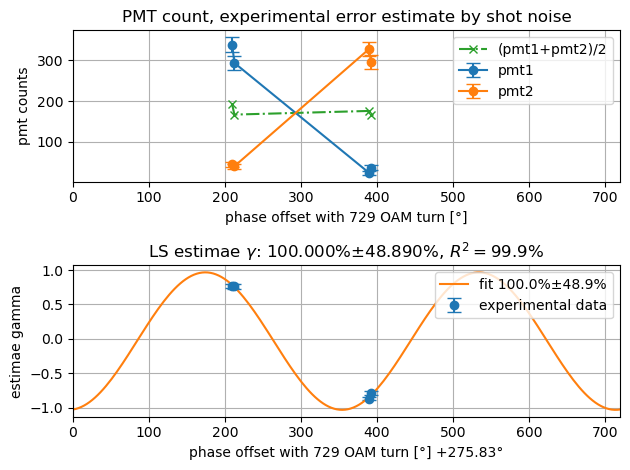

-------------Ref data-----------------
Fitted parameters: gamma=0.643±0.831, phase_offset=0.000±0.777, R²=98.920%


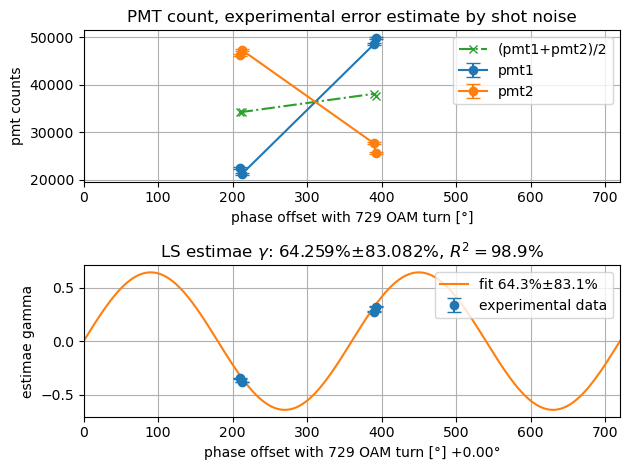

In [699]:
out_csv='gamma_res_time.csv'
res_data=pd.read_csv(out_csv)
count2gamma(res_data)
res_data.sort_values(by='turn',inplace=True)
origin_df=res_data[res_data['state']=='origin']
monitor_df=res_data[res_data['state']=='monitor']
print('-------------origin data-----------------')
param_origin,param_origin_err=estimate_gamma(origin_df,model_func=model_func_count_offset)
plt.savefig('gamma_fit.jpeg', dpi=300)
plt.show()
print('-------------Ref data-----------------')
param_monitor,param_monitor_err=estimate_gamma(monitor_df,model_func=model_func_sin)
plt.savefig('gamma_fit_ref.jpeg', dpi=300)
plt.show()

In [700]:
best_phi_list=np.array([90,180,270,360,450,540,630])+param_origin[1]/np.pi*180//90*90
best_turn_list=(best_phi_list-(param_origin[1]/np.pi*180))/360/2
phase_array=np.linspace(0,360*2,500)
turn_array=phase_array/360/2
origin_fit=model_func_count_offset(phase_array,*param_origin)
best_phase_list=best_turn_list*2*360

fig = px.scatter(origin_df, x='phase', y='gamma',error_y='gamma_err',hover_data='turn',title='origin data, estimate gamma : {:.3%}'.format(np.abs(param_origin[0])))
fig.add_scatter(x=phase_array, y=origin_fit, mode='lines', name='Cos Fit',hovertext=['turn={:.3}'.format(i) for i in turn_array],hovertemplate='gamma=%{y:.3f}<br>%{hovertext}')
fig.add_scatter(x=best_phase_list,y=model_func_count_offset(best_phase_list,*param_origin),mode='markers',name='best phi',hovertext=['turn={:.3}'.format(i) for i in best_turn_list],hovertemplate='gamma=%{y:.3f}<br>%{hovertext}')
fig.show()